# Generate Dataframe of Incident Status Information

pwd

In [1]:
cd ..

e:\two_stage_model\data_processing


In [2]:
import geopandas as gpd
import pandas as pd
import pickle
import datetime
import numpy as np
import glob
import os

from datetime import datetime as dt
from shapely.geometry import Point
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from bisect import bisect_left

In [3]:
country_name = 'Cranberry'
model_path = 'E:/two_stage_model'
# Hyperparamter
# Time
start_date = dt(2022, 2, 1)
end_date = dt(2024, 1, 31)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 260 business dates
datetime_index = pd.bdate_range(start=start_date, end=end_date+datetime.timedelta(days=1),freq="5min")
upstream_range_mile = 0.3 # keep same when calculate slowdown speed
minimum_abnormal_sd_length = 3 # every 5 min, meaning larger than 15 min regard as incident

In [4]:
upstream_range_mile = float("{:.1f}".format(upstream_range_mile))

# 1. Merage Data into one csv file
### Attention! Only Excute this block if {country_name}_df_inc_raw.pkl is not in this folder

In [5]:
merged_inc_dfs = []

In [6]:
incident_files = glob.glob(f'{model_path}/data/{country_name}/incident_raw' + '/*.csv')

In [7]:
for file_path in incident_files:
    single_inc_df = pd.read_csv(file_path)
    merged_inc_dfs.append(single_inc_df)

In [8]:
merged_inc_df_raw = pd.concat(merged_inc_dfs, axis=0)

In [9]:
merged_inc_df_raw

Event ID                System Agency  \
0      WAZE_f10ba73d-9b85-4449-87d4-d1bb38a12c1f                  Waze   Waze   
1      WAZE_4a6840d4-c114-484f-96a1-09e5a513c995                  Waze   Waze   
2      WAZE_6fd4a8f5-db51-4763-9855-4afa199b970e                  Waze   Waze   
3      WAZE_75bdbe65-af9b-4dc2-813c-d98447cd5624                  Waze   Waze   
4      WAZE_5e96ea64-19a6-4408-acef-c0eb0c8e5347                  Waze   Waze   
...                                          ...                   ...    ...   
32657  HERE_c50565ab-3123-42e7-8b38-b37d43d124eb  HERE Hazard Warnings   HERE   
32658  HERE_8cb1a878-5862-4392-8d2e-f4b6cffbc8eb  HERE Hazard Warnings   HERE   
32659  HERE_a1b66bbf-1305-4acd-ac67-cdefce84ced9  HERE Hazard Warnings   HERE   
32660  HERE_c9072a34-e101-4071-84b3-2a1b3f0f840a  HERE Hazard Warnings   HERE   
32661  HERE_4e3c6e36-2397-4e0e-9eed-687479757c3a  HERE Hazard Warnings   HERE   

               Standardized Type Agency-specific Type  \
0              Construction Work        Weatherhazard   
1              Construction Work        Weatherhazard   
2      Congestion Due to Closure          Road Closed   
3                       Incident             Accident   
4              Construction Work        Weatherhazard   
...                          ...                  ...   
32657          Weather Condition  Slippery Road Event   
32658          Weather Condition  Slippery Road Event   
32659          Weather Condition  Slippery Road Event   
32660          Weather Condition  Slippery Road Event   
32661          Weather Condition  Slippery Road Event   

          Agency-specific Sub Type                 Start time  \
0      Hazard On Road Construction  2022-02-01T09:36:03-05:00   
1      Hazard On Road Construction  2022-02-01T09:00:15-05:00   
2         Road Closed Construction  2022-02-01T17:15:28-05:00   
3                              NaN  2022-02-01T12:02:27-05:00   
4      Hazard On Road Construction  2022-02-01T09:50:46-05:00   
...                            ...                        ...   
32657                          NaN  2024-01-19T08:34:40-05:00   
32658                          NaN  2024-01-19T11:32:48-05:00   
32659                          NaN  2024-01-19T17:13:05-05:00   
32660                          NaN  2024-01-19T06:35:51-05:00   
32661                          NaN  2024-01-19T22:31:40-05:00   

                     Closed time Open/Closed          Location  ...  \
0      2022-02-01T10:09:42-05:00      Closed           27TH ST  ...   
1      2022-02-01T09:41:21-05:00      Closed          ONE WILD  ...   
2      2022-02-01T18:18:43-05:00      Closed        SECOND AVE  ...   
3      2022-02-01T12:35:51-05:00      Closed           5TH AVE  ...   
4      2022-02-01T10:22:33-05:00      Closed           RODI RD  ...   
...                          ...         ...               ...  ...   
32657  2024-01-19T09:04:40-05:00      Closed  Unknown Location  ...   
32658  2024-01-19T12:02:48-05:00      Closed  Unknown Location  ...   
32659  2024-01-19T17:43:05-05:00      Closed  Unknown Location  ...   
32660  2024-01-19T07:05:51-05:00      Closed  Unknown Location  ...   
32661  2024-01-19T23:01:40-05:00      Closed  Unknown Location  ...   

      Duration (Incident clearance time) Operator Notes  Notifications Sent  \
0                             33 minutes            NaN                 NaN   
1                             41 minutes            NaN                 NaN   
2                       1 hour 3 minutes            NaN                 NaN   
3                             33 minutes            NaN                 NaN   
4                             31 minutes            NaN                 NaN   
...                                  ...            ...                 ...   
32657                         30 minutes            NaN                 NaN   
32658                         30 minutes            NaN                 NaN   
32659                         30 minu

In [10]:
print('Incident Type Includes', list(set(merged_inc_df_raw['Standardized Type'])))
print('Agency-specific Type Includes', list(set(merged_inc_df_raw['Agency-specific Type'])))
print('Agency-specific Sub Type Includes', list(set(merged_inc_df_raw['Agency-specific Sub Type'])))
print('Incident Source Includes', list(set(merged_inc_df_raw['System'])))
print('Column Includes', list(set(merged_inc_df_raw.columns)))
print('Country Includes', list(set(merged_inc_df_raw['County'])))

Incident Type Includes ['Obstruction due to Animals On Roadway', 'Collision', 'Animal Struck', 'Obstructions', 'Rain', 'Traffic Signal Not Working', 'Special Event', 'Incident', 'Congestion', 'Weather Condition', 'Flood', 'Construction Work', 'Winter Road Report', 'Foggy Conditions', 'Congestion Due to Closure', 'Icy Conditions']
Agency-specific Type Includes ['Road Closed', 'Crash', 'Rain Event', 'Hazard', 'Weatherhazard', 'Accident Event', 'Multi Vehicle Crash', 'Slippery Road Event', 'Accident', 'Fog Event', 'Vehicle Fire', 'Downed Tree', 'Flooding', 'Winter Weather', 'Special Event']
Agency-specific Sub Type Includes ['Hazard On Shoulder Animals', 'Hazard On Road Object', 'Hazard Weather Fog', 'Road Closed Event', 'Hazard On Road Lane Closed', 'Hazard Weather', 'Hazard On Road Road Kill', 'Hazard On Road Pot Hole', 'Hazard On Road', 'Accident Major', 'Hazard On Shoulder Missing Sign', 'Hazard Weather Flood', nan, 'Road Closed Construction', 'Hazard On Road Construction', 'Hazard We

In [11]:
pickle.dump(merged_inc_df_raw, open(f'{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl', "wb"))

# 2. Load Geo and Speed Information

 - load geo information

In [12]:
gdf_tmc_raw = gpd.read_file(f'{model_path}/data/{country_name}/geo_info/{country_name}_tmc_shape_for_sjoin.geojson')
gdf_tmc_raw = gdf_tmc_raw.rename(columns={"tmc":"id_tmc"})

In [13]:
print(list(set(gdf_tmc_raw['roadname'])))
print(list(set(gdf_tmc_raw['roadnumber'])))

['FORBES AVE', 'PA-8 N', 'BUTLER ST', 'WILLIAM FLYNN HWY', 'PA-228 W', '10TH ST BYP', 'CORAOPOLIS RD', 'BLUE BELT/MCKEES ROCKS BRG', 'ROCHESTER RD', 'PA-28 N', 'REEDSDALE ST', 'RIVER ST', 'STANWIX ST', 'FEDERAL ST', 'I-376 E', 'N SHORE DR', 'EVANS CITY RD', 'HOPEWELL AVE', '7TH AVE', 'MCGOVERN BLVD', 'ROBINSON BLVD', 'DELAWARE AVE', 'SEWICKLEY BRG', 'MONACA-ROCHESTER BRG', 'LOWRIES RUN RD', 'PA-51 N', 'MASSACHUSETTS AVE', 'STATE AVE', 'WILLIAM FLINN HWY', 'PA-8 S', '1C', 'BIG BEAVER BLVD', 'TONY DORSETT DR', 'HIGHLAND PARK BRG', 'PA-228', '2A', '5TH ST', 'GRANT AVE', 'NORTH AVE', 'JORDAN ST', 'W CARSON ST', 'ANDERSON ST', 'GRAND AVE', 'CAMP HORNE RD/GREEN BELT', 'PA-51 S', 'W CUNNINGHAM ST', 'GREEN BELT', 'ADAMS ST', 'YELLOW BELT', 'STEUBEN ST', '11TH ST', 'E JEFFERSON ST', 'S MAIN ST', 'STOCKTON AVE', 'US-19', 'W NEW CASTLE ST', 'I-279 S', 'PA-356 N', 'HANSEN AVE', '16TH ST', '3RD ST', 'US-422', 'LIBERTY AVE', 'BLOOMFIELD BRG', 'STOOPS FERRY RD', 'I-579 N', 'BEAVER-ROCHESTER BRG', 'US

In [14]:
list(gdf_tmc_raw[gdf_tmc_raw['roadnumber']=='I-70']['id_tmc'])

[]

 - load upstream k mile dict

In [15]:
upstream_k_mile_dict =  pickle.load(open(f"{model_path}/data/{country_name}/processed_data/upstream_rage_dict/{country_name}_upstream_{upstream_range_mile}_mile.pkl", "rb"))

 - load dict_prev_tmc

In [16]:
dict_prev_tmc = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_dict_prev_tmc.pkl", "rb"))

 - load speed information

In [17]:
spd_record_all = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_from_1_min.pkl", "rb"))

In [18]:
speed_available_tmc_list = list(spd_record_all.columns)

 - load slowdown speed

In [19]:
df_slowdown_speed = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_slowdown_speed.pkl", "rb"))

# 3 Select TMC segement for analysis

 - get selected TMC segement list
 - Currently, we adopt the rule that selects the link where all speed data (all, pv, truck) are available, so that it depends on 0_Generate_Speed.ipynb

In [20]:
spd_record_selected = pickle.load(open(f"{model_path}/data/{country_name}/processed_data/{country_name}_df_spd_tmc_5min_all_selected.pkl", "rb"))
selected_tmc_list = list(spd_record_selected.columns)

In [21]:
gdf_tmc_selected = gdf_tmc_raw[gdf_tmc_raw['id_tmc'].isin(selected_tmc_list)]

In [22]:
gdf_tmc_selected_polygon = gdf_tmc_selected.copy()
gdf_tmc_selected_polygon["geometry"] = gdf_tmc_selected.to_crs(epsg=3857).buffer(distance=10, resolution=1).to_crs(epsg=4326)

# 4 Process Incident Dataframe
 - load incident information

In [23]:
merged_inc_df_raw = pickle.load(open(f"{model_path}/data_processing/Incident_Manual_Check/{country_name}_df_inc_raw.pkl", "rb")) 

## 4.1 Clean Date and Time

In [24]:
merged_inc_df_raw = merged_inc_df_raw[~((merged_inc_df_raw["Closed time"].isna()) & (merged_inc_df_raw["Duration (Incident clearance time)"].isna()))] 

In [25]:
merged_inc_df_raw["dt_start"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Start time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_end"] = merged_inc_df_raw.apply(lambda x: dt.strptime(x["Closed time"][:-6], '%Y-%m-%dT%H:%M:%S'), axis=1)
merged_inc_df_raw["dt_duration"] = merged_inc_df_raw["dt_end"] - merged_inc_df_raw["dt_start"]

## 4.2 Perform spatial join to map incident location to TMC segment(s)

In [26]:
# Note: gpd.GeoDataFrame() is inplace, so I supply TSMO_df_inc_raw.copy() here
gdf_inc_point = gpd.GeoDataFrame(
                    merged_inc_df_raw.copy(), crs={'init': 'epsg:4326'},
                    geometry=[Point(xy) for xy in zip(merged_inc_df_raw["Longitude"], merged_inc_df_raw["Latitude"])]) # (163140, 34)

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [27]:
gdf_inc_point = gdf_inc_point[~((gdf_inc_point.Latitude.isna()) | (gdf_inc_point.Longitude.isna()))] # (163139, 34)

<Axes: >

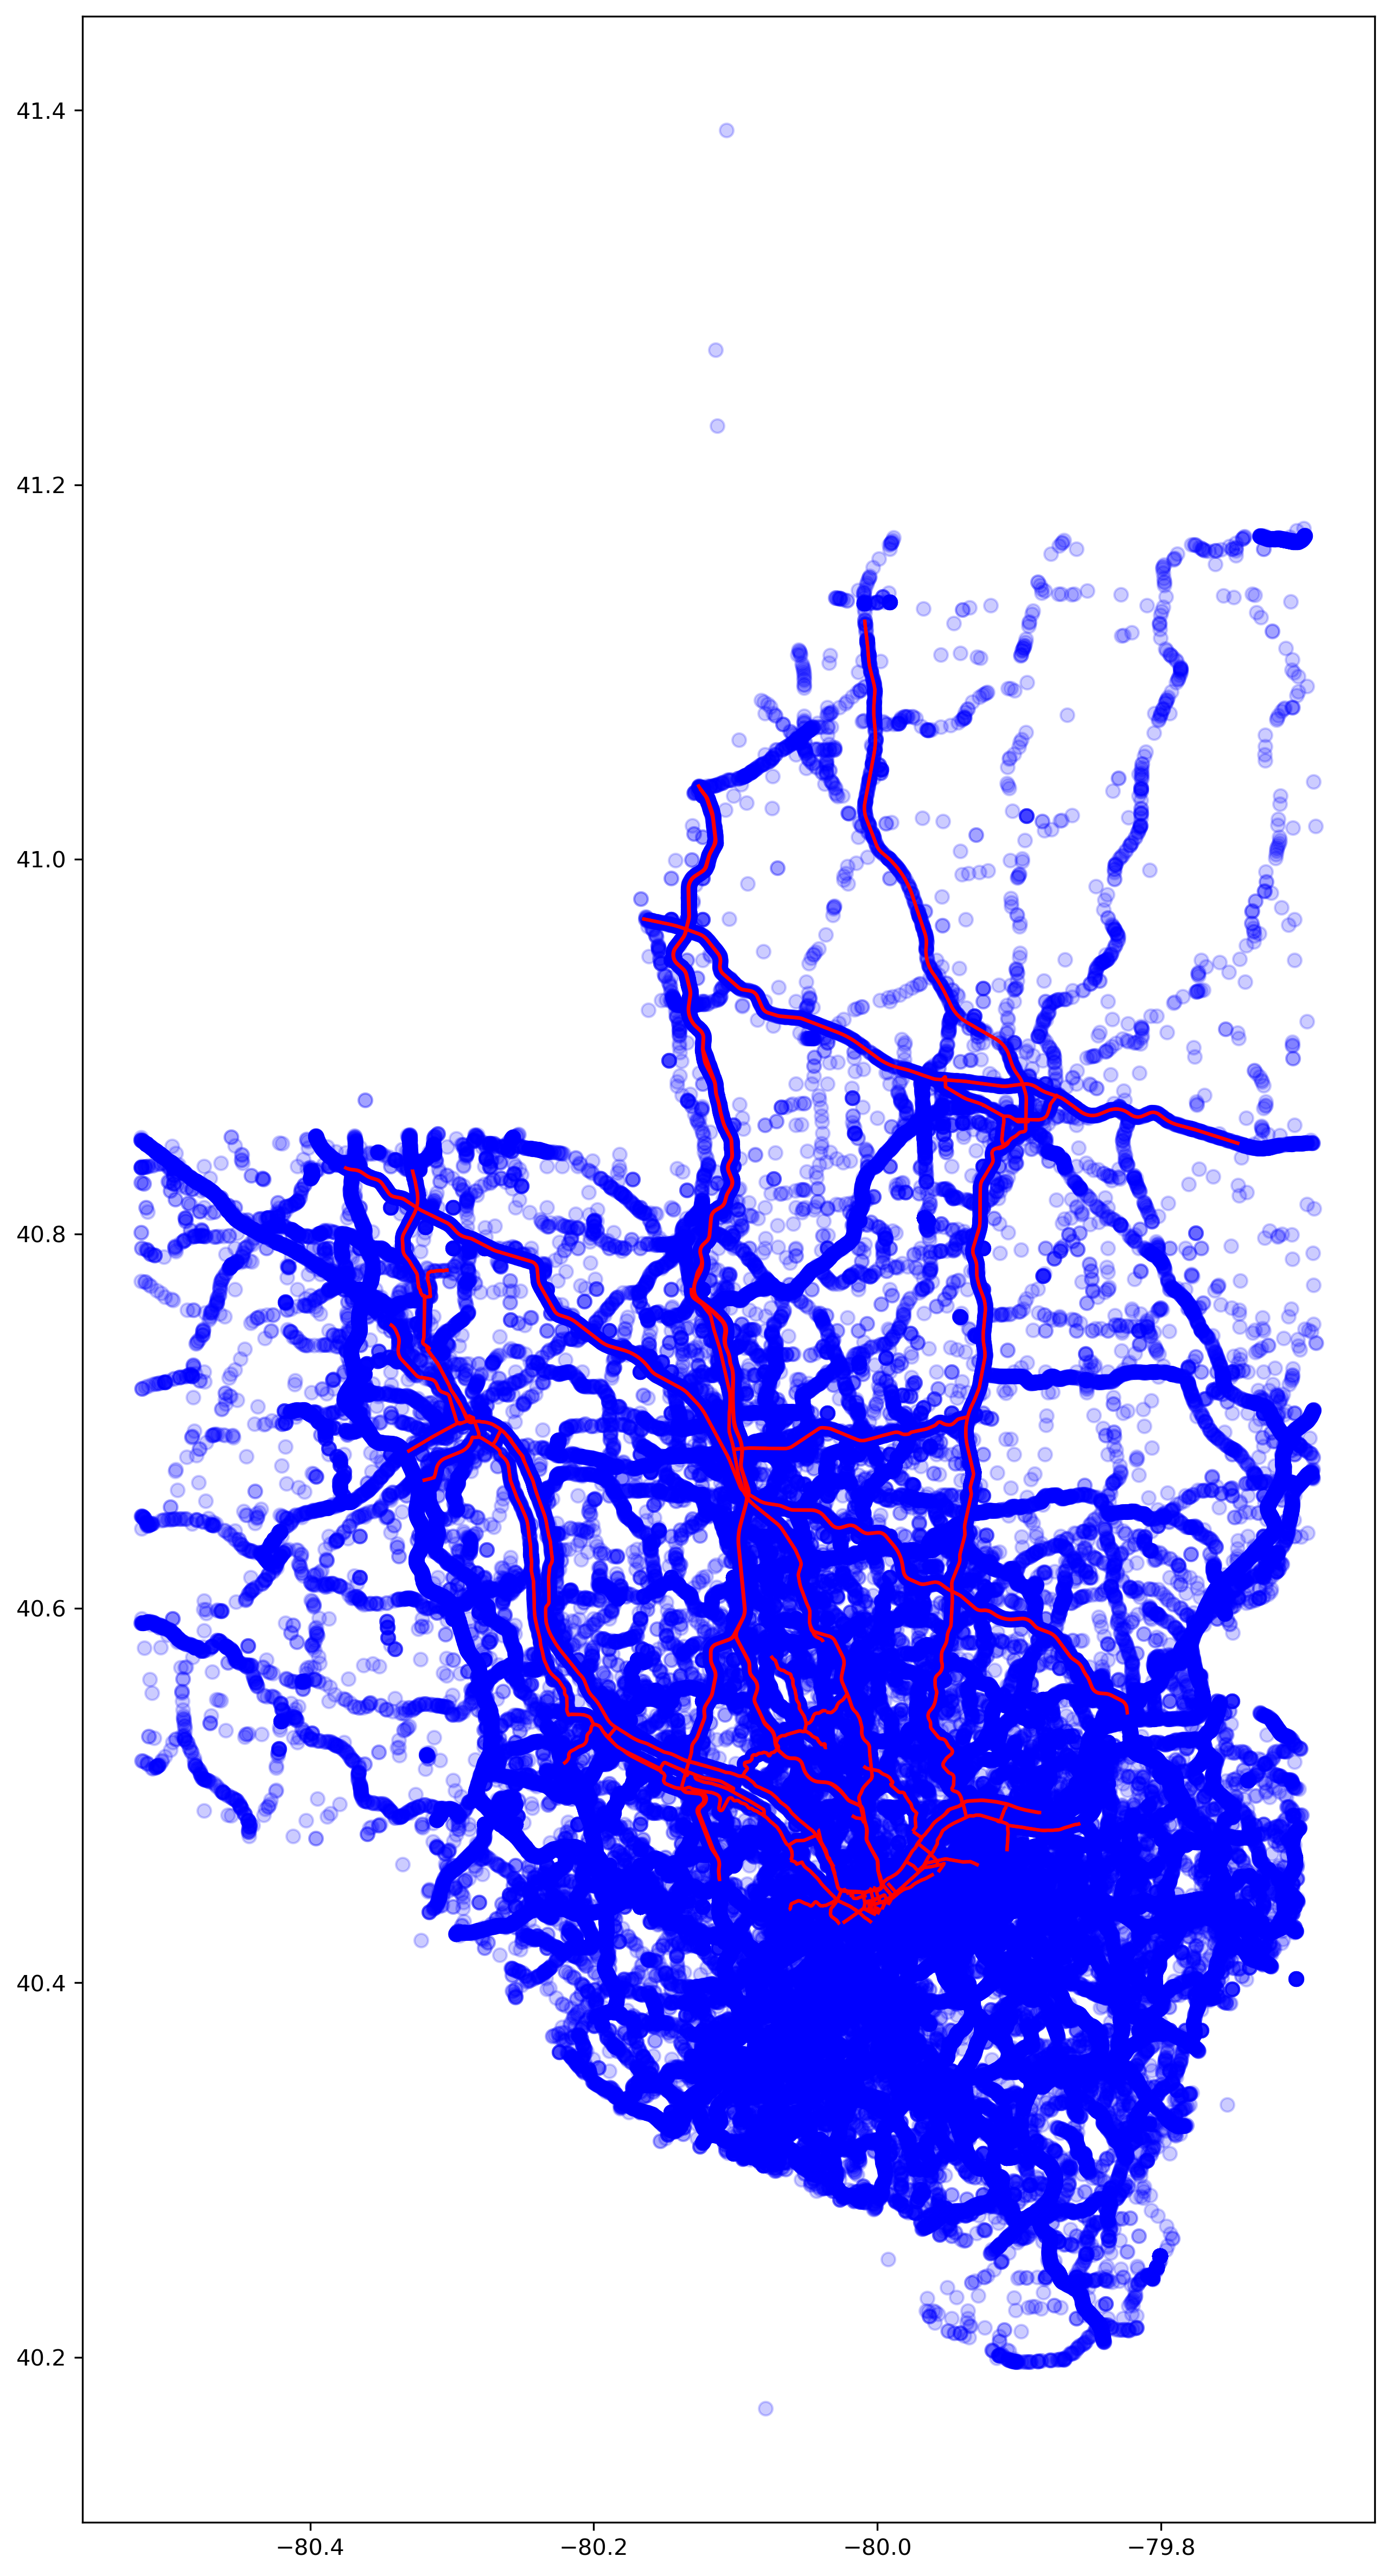

In [28]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_inc_point.plot(ax=ax, color="blue", alpha=0.2)
gdf_tmc_selected.plot(ax=ax, color = "red")

In [29]:
gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_selected_polygon, how="left", op="within")  

c:\Users\haowu\Anaconda3\envs\traffic\lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\haowu\AppData\Local\Temp\ipykernel_1240112\1651549596.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  gdf_inc_point_matched_with_tmc = gpd.sjoin(left_df=gdf_inc_point, right_df= gdf_tmc_selected_polygon, how="left", op="within")


In [30]:
gdf_inc_record_all = gdf_inc_point_matched_with_tmc[~gdf_inc_point_matched_with_tmc.id_tmc.isna()]  

<Axes: >

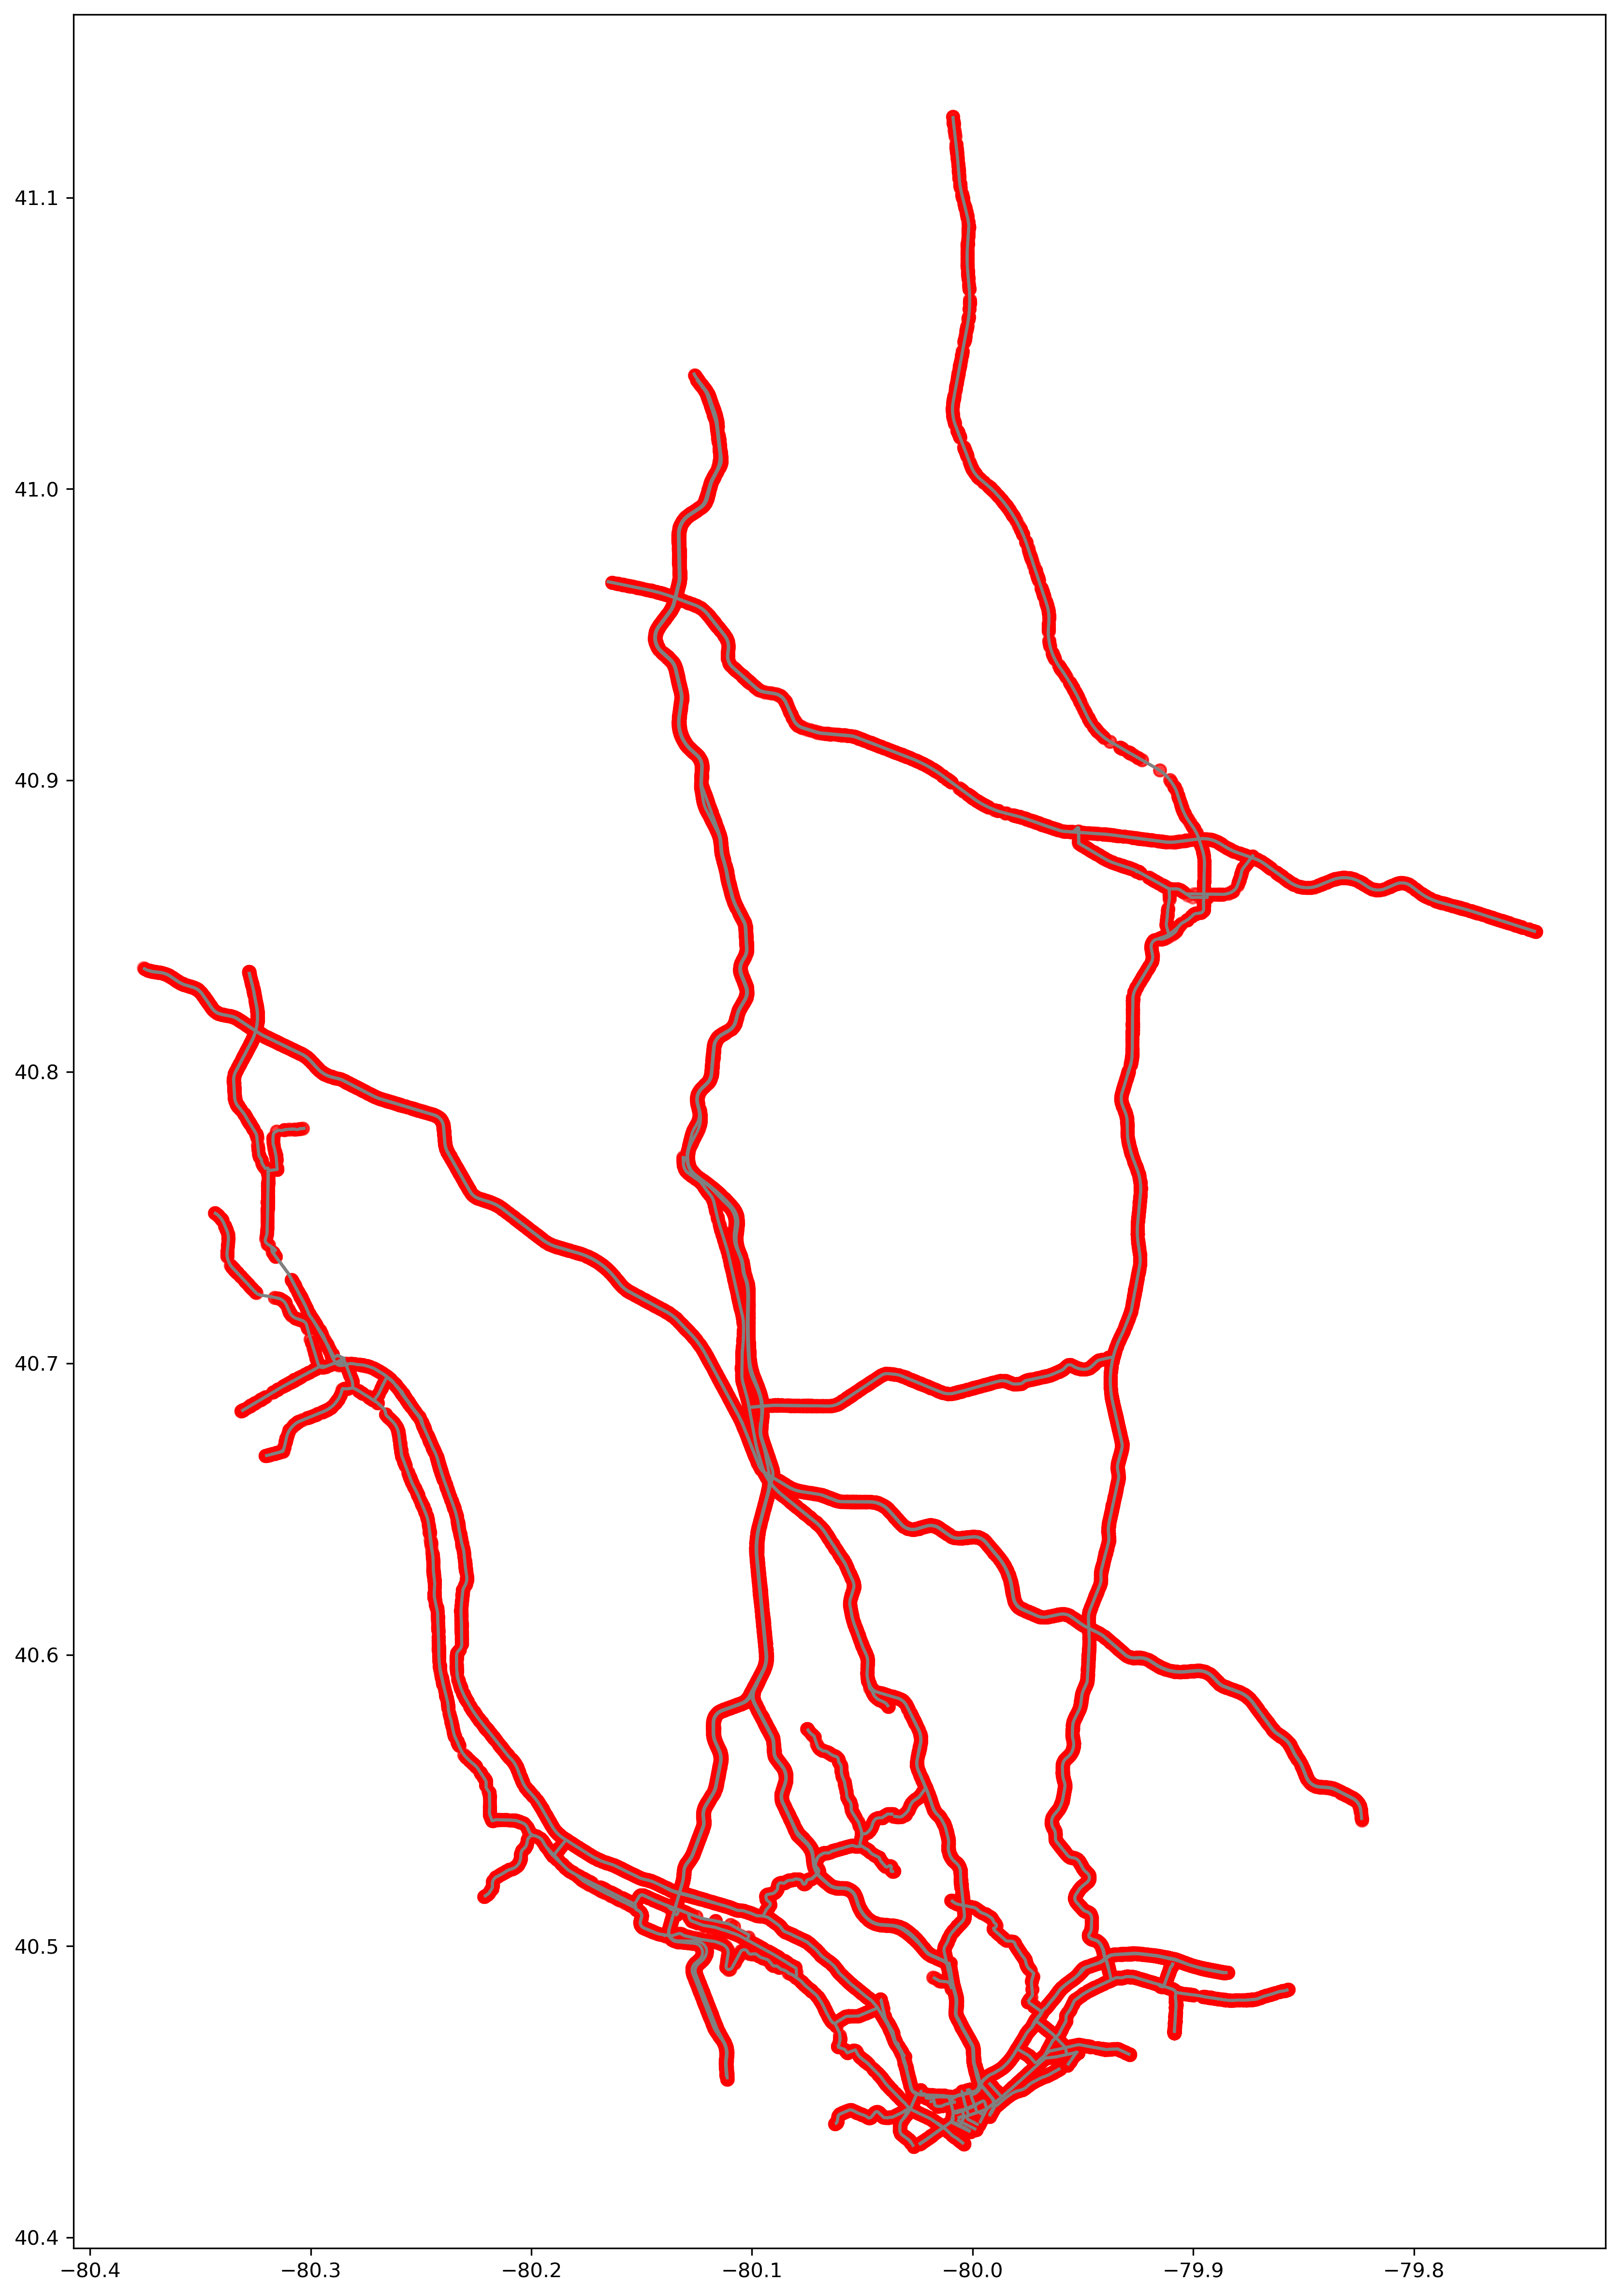

In [31]:
# Visualize Incident Location Points of All Time from Feb 14, 2022 to Feb 12, 2023
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_tmc_selected.plot(ax=ax, color = "grey")
gdf_inc_record_all.plot(ax=ax, color="red", alpha = 0.5)

In [32]:
pickle.dump(gdf_inc_record_all, open(f"./Incident_Manual_Check/{country_name}_gdf_inc_record_all.pkl", "wb"))

In [33]:
gdf_inc_record_all

Event ID                System Agency  \
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
12     WAZE_0046ed2e-d542-467f-805d-11cf0b6b5485                  Waze   Waze   
...                                          ...                   ...    ...   
32612  HERE_6bd34771-2a98-4636-9a34-b0f0e0c60eb6  HERE Hazard Warnings   HERE   
32614  HERE_4e0fbfb3-43a8-4f7f-9068-5ace065df530  HERE Hazard Warnings   HERE   
32626  HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33  HERE Hazard Warnings   HERE   
32626  HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33  HERE Hazard Warnings   HERE   
32660  HERE_c9072a34-e101-4071-84b3-2a1b3f0f840a  HERE Hazard Warnings   HERE   

       Standardized Type Agency-specific Type     Agency-specific Sub Type  \
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
12     Construction Work        Weatherhazard  Hazard On Road Construction   
...                  ...                  ...                          ...   
32612  Weather Condition  Slippery Road Event                          NaN   
32614  Weather Condition  Slippery Road Event                          NaN   
32626  Weather Condition  Slippery Road Event                          NaN   
32626  Weather Condition  Slippery Road Event                          NaN   
32660  Weather Condition  Slippery Road Event                          NaN   

                      Start time                Closed time Open/Closed  \
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
12     2022-02-01T15:15:29-05:00  2022-02-01T16:41:35-05:00      Closed   
...                          ...                        ...         ...   
32612  2024-01-19T21:50:46-05:00  2024-01-19T22:20:46-05:00      Closed   
32614  2024-01-19T08:31:17-05:00  2024-01-19T09:01:17-05:00      Closed   
32626  2024-01-19T19:31:32-05:00  2024-01-19T20:01:32-05:00      Closed   
32626  2024-01-19T19:31:32-05:00  2024-01-19T20:01:32-05:00      Closed   
32660  2024-01-19T06:35:51-05:00  2024-01-19T07:05:51-05:00      Closed   

               Location  ... road_order     roadname  roadnumber     county  \
9                 SR-28  ...     95.000   GREEN BELT        PA-8  ALLEGHENY   
9                 SR-28  ...      1.000          NaN         NaN  ALLEGHENY   
9                 SR-28  ...      1.000          NaN         NaN  ALLEGHENY   
9                 SR-28  ...     10.000   GREEN BELT        PA-8  ALLEGHENY   
12                 I-76  ...     12.000       I-76 E        I-76     BUTLER   
...                 ...  ...        ...          ...         ...        ...   
32612  Unknown Location  ...      1.000  10TH ST BYP         NaN  ALLEGHENY   
32614  Unknown Location  ...      7.500   FORBES AVE         NaN  ALLEGHENY   
32626  Unknown Location  ...     66.001        PA-51       US-19  ALLEGHENY   
32626  Unknown Location  ...    691.000        PA-51       US-19  ALLEGHENY   
32660  Unknown Location  ...     47.000      PA-28 S       PA-28  ALLEGHENY   

      state    zip start_latitude start_longitude end_latitude end_longitude  
9        PA  15206       40.48691       -79.91596     40.48557     -79.91073  
9        PA  15206       40.48659       -79.91324     40.48637     -79.91383  
9        PA  15206       40.48691       -79

## 4.3. Finalize Spatial-temporal Dataframe of Incident Status
-Make spatial-temporal dataframe of incident status

In [34]:
gdf_inc_record_all = pickle.load(open(f"./Incident_Manual_Check/{country_name}_gdf_inc_record_all.pkl", "rb"))

In [35]:
# Make sure start and/or end date falls into business dates
gdf_inc_record_all_filtered_date = gdf_inc_record_all[
    (gdf_inc_record_all.dt_start.dt.date.isin(busi_date)) | (gdf_inc_record_all.dt_end.dt.date.isin(busi_date))
    ]  # (29800, 52)


# Make sure start and/or end time falls into business hours
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date[
                ((gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_start.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_start.dt.hour*60 +gdf_inc_record_all_filtered_date.dt_start.dt.minute < end_time)) |
                ((gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute >= start_time) & (gdf_inc_record_all_filtered_date.dt_end.dt.hour*60 + gdf_inc_record_all_filtered_date.dt_end.dt.minute < end_time)) 
            ]  # (26984, 52)

In [36]:
gdf_inc_record_all_filtered_date_time = gdf_inc_record_all_filtered_date_time[gdf_inc_record_all_filtered_date_time.dt_start.dt.date == gdf_inc_record_all_filtered_date_time.dt_end.dt.date]

In [37]:
gdf_inc_record_all_filtered_date_time

Event ID                System Agency  \
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
9      WAZE_e87a38c5-7f98-488d-afa3-a36e6d1c55b1                  Waze   Waze   
12     WAZE_0046ed2e-d542-467f-805d-11cf0b6b5485                  Waze   Waze   
...                                          ...                   ...    ...   
32600  HERE_a5a0882f-fa29-494c-9334-e0efb25bd3d3  HERE Hazard Warnings   HERE   
32614  HERE_4e0fbfb3-43a8-4f7f-9068-5ace065df530  HERE Hazard Warnings   HERE   
32626  HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33  HERE Hazard Warnings   HERE   
32626  HERE_9c6ab284-03fd-4d12-ad98-5497c14d3b33  HERE Hazard Warnings   HERE   
32660  HERE_c9072a34-e101-4071-84b3-2a1b3f0f840a  HERE Hazard Warnings   HERE   

       Standardized Type Agency-specific Type     Agency-specific Sub Type  \
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
9           Obstructions        Weatherhazard      Hazard On Road Pot Hole   
12     Construction Work        Weatherhazard  Hazard On Road Construction   
...                  ...                  ...                          ...   
32600  Weather Condition  Slippery Road Event                          NaN   
32614  Weather Condition  Slippery Road Event                          NaN   
32626  Weather Condition  Slippery Road Event                          NaN   
32626  Weather Condition  Slippery Road Event                          NaN   
32660  Weather Condition  Slippery Road Event                          NaN   

                      Start time                Closed time Open/Closed  \
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
9      2022-02-01T05:15:13-05:00  2022-02-01T09:20:20-05:00      Closed   
12     2022-02-01T15:15:29-05:00  2022-02-01T16:41:35-05:00      Closed   
...                          ...                        ...         ...   
32600  2024-01-19T14:46:38-05:00  2024-01-19T15:16:38-05:00      Closed   
32614  2024-01-19T08:31:17-05:00  2024-01-19T09:01:17-05:00      Closed   
32626  2024-01-19T19:31:32-05:00  2024-01-19T20:01:32-05:00      Closed   
32626  2024-01-19T19:31:32-05:00  2024-01-19T20:01:32-05:00      Closed   
32660  2024-01-19T06:35:51-05:00  2024-01-19T07:05:51-05:00      Closed   

               Location  ... road_order    roadname  roadnumber     county  \
9                 SR-28  ...     95.000  GREEN BELT        PA-8  ALLEGHENY   
9                 SR-28  ...      1.000         NaN         NaN  ALLEGHENY   
9                 SR-28  ...      1.000         NaN         NaN  ALLEGHENY   
9                 SR-28  ...     10.000  GREEN BELT        PA-8  ALLEGHENY   
12                 I-76  ...     12.000      I-76 E        I-76     BUTLER   
...                 ...  ...        ...         ...         ...        ...   
32600  Unknown Location  ...     15.500      I-76 E        I-76  ALLEGHENY   
32614  Unknown Location  ...      7.500  FORBES AVE         NaN  ALLEGHENY   
32626  Unknown Location  ...     66.001       PA-51       US-19  ALLEGHENY   
32626  Unknown Location  ...    691.000       PA-51       US-19  ALLEGHENY   
32660  Unknown Location  ...     47.000     PA-28 S       PA-28  ALLEGHENY   

      state    zip start_latitude start_longitude end_latitude end_longitude  
9        PA  15206       40.48691       -79.91596     40.48557     -79.91073  
9        PA  15206       40.48659       -79.91324     40.48637     -79.91383  
9        PA  15206       40.48691       -79.91596     4

In [39]:
df_inc = pd.DataFrame(data=0.0,index=datetime_index,columns=list(set(gdf_tmc_raw.id_tmc))) 

In [40]:
df_inc = df_inc[
        (pd.to_datetime(df_inc.index.date).isin(busi_date)) &   # be careful about the syntax here, dealing with index filtering is really annoying
        (df_inc.index.hour*60 + df_inc.index.minute >= start_time) &
        (df_inc.index.hour*60 + df_inc.index.minute < end_time) 
    ] 

In [41]:
df_inc

104-51833  104P04517  104+04540  104P13473  104N08097  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     104N13473  104P04717  104+08944  104P09249  104N04635  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     ...  104+04524  104P04641  104N04632  104N04522  \
2022-02-01 05:30:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00  ...        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2024-01-31 20:35:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00  ...        0.0        0.0        0.0        0.0   

                     104N04706  104+50442  104+13515  104P13682  104-09091  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     104N04682  
2022-02-01 05:30:00        0.0  
2022-02-01 05:35:00        0.0  
2022-02-01 05:40:00        0.0  
2022-02-01 05:45:00        0.0  
2022-02-01 05:50:00        0.0  
...                        ...  
2024-01-31 20:35:00        0.0  
2024-01-31 20:40:00        0.0  
2024-01-31 20:45:00        0.0  
2024-01-31 20:5

In [42]:
def earliest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.min()

In [43]:
def find_earlier_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if time_list[position-1].date()!=query_time.date():
        return earliest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
    else:
        return time_list[position-1] # if position else None

In [44]:
def latest_time_for_date(index, date_str):
    filtered_times = index[index.date == pd.Timestamp(date_str).date()]
    return filtered_times.max()

In [45]:
def find_later_time(time_list, query_time):
    position = bisect_left(time_list, query_time)
    if position < len(time_list):
        if time_list[position].date()!=query_time.date():
            return latest_time_for_date(time_list, query_time.date()) if position < len(time_list) else None
        else:
            return time_list[position]  
    else:
        return max(time_list)

### 4.3.1 Check if there is any incident whose assigned start date and end date are different

In [55]:
for i in tqdm(range(len(gdf_inc_record_all_filtered_date_time))):
    start = gdf_inc_record_all_filtered_date_time.iloc[i].dt_start
    end = gdf_inc_record_all_filtered_date_time.iloc[i].dt_end
    id_tmc = gdf_inc_record_all_filtered_date_time.iloc[i].id_tmc
    # df_inc_waze[(df_inc_waze.index >= start) & (df_inc_waze.index < end)][id_tmc] = 1.0 # this won't work as it will return a view instead of changing value in place
    df_inc.loc[find_earlier_time(df_inc.index, start): find_later_time(df_inc.index, end), id_tmc] = 1.0

  0%|          | 0/85941 [00:00<?, ?it/s]

100%|██████████| 85941/85941 [01:55<00:00, 742.66it/s] 


In [56]:
df_inc

104-51833  104P04517  104+04540  104P13473  104N08097  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     104N13473  104P04717  104+08944  104P09249  104N04635  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     ...  104+04524  104P04641  104N04632  104N04522  \
2022-02-01 05:30:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00  ...        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00  ...        0.0        0.0        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2024-01-31 20:35:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00  ...        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00  ...        0.0        0.0        0.0        0.0   

                     104N04706  104+50442  104+13515  104P13682  104-09091  \
2022-02-01 05:30:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:35:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:40:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:45:00        0.0        0.0        0.0        0.0        0.0   
2022-02-01 05:50:00        0.0        0.0        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2024-01-31 20:35:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:40:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:45:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:50:00        0.0        0.0        0.0        0.0        0.0   
2024-01-31 20:55:00        0.0        0.0        0.0        0.0        0.0   

                     104N04682  
2022-02-01 05:30:00        0.0  
2022-02-01 05:35:00        0.0  
2022-02-01 05:40:00        0.0  
2022-02-01 05:45:00        0.0  
2022-02-01 05:50:00        0.0  
...                        ...  
2024-01-31 20:35:00        0.0  
2024-01-31 20:40:00        0.0  
2024-01-31 20:45:00        0.0  
2024-01-31 20:5

In [57]:
np.count_nonzero(df_inc) # 1300525

1300525

## 4.1 demo example

# 5. Calculate Selected Link Slowdown Speed
-only calculate speed of selected links, however, when calculating upstream speed, we will use include links not in the selcted links

## 5.1. Calculate Average Recurrent Slowdown Speed (Currently Not Used)

## 5.2 Function to Label Incidents
 -Function to Mark Incidents that contains Significant Large Slowdown Speed

In [48]:
def label_all_incident_contain_significant_sd(raw_inc_list = list, sign_sd_list = list, day_number = int):
    day_list_length = int(len(raw_inc_list)/day_number)
    matched_incident_list = []
    for day_index in range(day_number):
        day_raw_inc_list = raw_inc_list[day_index*day_list_length:(day_index+1)*day_list_length]
        day_sign_sd_list = sign_sd_list[day_index*day_list_length:(day_index+1)*day_list_length]
        sum_list = [x + y for x, y in zip(day_raw_inc_list, day_sign_sd_list)]
        overlap_list = [1 if value==2 else 0 for value in sum_list]
        overlap_index = [index for index, value in enumerate(sum_list) if value == 2]
        for index in overlap_index:
            i = 1
            while (index-i)>=0:
                if day_raw_inc_list[index-i]==1:
                    overlap_list[index-i]=1
                    i+=1
                else:
                    break
            j = 1
            while (index+j)<day_list_length:
                if day_raw_inc_list[index+j]==1:
                    overlap_list[index+j]=1
                    j+=1
                else:
                    break
        matched_incident_list.extend(overlap_list)
    return matched_incident_list

 -Function to Label Long-lasting Significant Lagre Slowdown Speed as Incident

In [49]:
def label_long_last_abnormal_sd_as_incident(sign_sd_list = list, minimum_length = int, day_number = int):
    day_list_length = int(len(sign_sd_list)/day_number)
    labelled_incident_list = []
    for day_index in range(day_number):
        day_sign_sd_list = sign_sd_list[day_index*day_list_length:(day_index+1)*day_list_length]
        
        day_label_as_inc_list = [0]*len(day_sign_sd_list)
        count_number = 0
        for time_index in range(len(day_sign_sd_list)):
            if day_sign_sd_list[time_index] == 1:
                count_number +=1
                if count_number >= minimum_length:
                    for index in range(time_index - count_number+1, time_index+1):
                        day_label_as_inc_list[index] = 1
            else:
                count_number = 0
        labelled_incident_list.extend(day_label_as_inc_list)
    return labelled_incident_list

# 6. Label All Selected Incidents

In [50]:
df_slowdown_indicator = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_sum_inc_and_slowdown_indicator = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_inc_contain_abnormal_sd = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_long_last_abnormal_sd = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)
df_final_selected_inc = pd.DataFrame(0, index=df_inc.index, columns=df_inc.columns)

In [51]:
# should run for each link
def Label_and_Output_Link_Info(link_id, perentile_threshold, abnormal_sd_length_threshold):
    print('For TMC link',link_id,', There are', round((df_inc[link_id ] == 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by Waze')
    df_slowdown_indicator[link_id] = (df_slowdown_speed[link_id] >= df_slowdown_speed[link_id].quantile(perentile_threshold)).astype(int)
    print('SD is', df_slowdown_speed[link_id].quantile(perentile_threshold))
    df_sum_inc_and_slowdown_indicator = df_inc + df_slowdown_indicator
    inc_in_top_sd_percentile_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_slowdown_indicator[link_id] == 1).sum()*100, 2)
    selected_inc_in_raw_inc_ratio = round((df_sum_inc_and_slowdown_indicator[link_id] == 2).sum()/(df_inc[link_id] == 1).sum()*100, 2)
    conncted_inc_list = label_all_incident_contain_significant_sd(list(df_inc[link_id]), list(df_slowdown_indicator[link_id]), len(busi_date))
    all_connected_ratio = round(sum(conncted_inc_list)/(df_inc[link_id] == 1).sum()*100, 2)
    print('For TMC link',link_id,', in top', (round((1-perentile_threshold)*100, 4)), '% slowdown speed points, there are', inc_in_top_sd_percentile_ratio, '% points that are labelled as Incident by Waze, making up', selected_inc_in_raw_inc_ratio,'% in raw Waze incidents points')
    print('-If we link those points together, there will be',all_connected_ratio, '% raw Incident points relates to abnormal slowdown speed')
    print('________abnormal_slowdown_speed________')
    df_inc_contain_abnormal_sd[link_id] = conncted_inc_list 
    df_long_last_abnormal_sd[link_id] = label_long_last_abnormal_sd_as_incident(list(df_slowdown_indicator[link_id]), abnormal_sd_length_threshold, len(busi_date))
    abnormal_ls_sd_raw_waze_ratio = round(sum(df_long_last_abnormal_sd[link_id] == 1)/(df_inc[link_id] == 1).sum(), 4)
    df_final_selected_inc[link_id] = df_long_last_abnormal_sd[link_id] | df_inc_contain_abnormal_sd[link_id]
    abnormal_sd_increase_ratio = round(((df_final_selected_inc[link_id] == 1).sum()/(df_inc_contain_abnormal_sd[link_id] == 1).sum())*100, 4)
    print('-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is', abnormal_ls_sd_raw_waze_ratio)
    print('-they increased final selected inc by', abnormal_sd_increase_ratio , '%')
    print('-finally, there are', round((df_final_selected_inc[link_id]== 1).sum()/len(df_inc[link_id].index), 6)*100,'% labelled as incident by us')
    return None

# US-19

In [133]:
Label_and_Output_Link_Info('104+06680', 0.88, minimum_abnormal_sd_length) 

For TMC link 104+06680 , There are 1.3419999999999999 % labelled as incident by Waze
SD is 0.4299999999999997
For TMC link 104+06680 , in top 12.0 % slowdown speed points, there are 1.24 % points that are labelled as Incident by Waze, making up 11.13 % in raw Waze incidents points
-If we link those points together, there will be 81.27 % raw Incident points relates to abnormal slowdown speed
________abnormal_slowdown_speed________
-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is 0.9309
-they increased final selected inc by 212.559 %
-finally, there are 2.3184 % labelled as incident by us


# I-79

In [63]:
Label_and_Output_Link_Info('104+04445', 0.93, minimum_abnormal_sd_length) 

For TMC link 104+04445 , There are 5.2033000000000005 % labelled as incident by Waze
SD is 5.0
For TMC link 104+04445 , in top 7.0 % slowdown speed points, there are 10.36 % points that are labelled as Incident by Waze, making up 15.82 % in raw Waze incidents points
-If we link those points together, there will be 60.79 % raw Incident points relates to abnormal slowdown speed
________abnormal_slowdown_speed________
-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is 0.3662
-they increased final selected inc by 142.1361 %
-finally, there are 4.495699999999999 % labelled as incident by us


In [61]:
Label_and_Output_Link_Info('104-04444', 0.95, minimum_abnormal_sd_length) 

For TMC link 104-04444 , There are 3.8066999999999998 % labelled as incident by Waze
SD is 8.5
For TMC link 104-04444 , in top 5.0 % slowdown speed points, there are 13.4 % points that are labelled as Incident by Waze, making up 19.4 % in raw Waze incidents points
-If we link those points together, there will be 64.88 % raw Incident points relates to abnormal slowdown speed
________abnormal_slowdown_speed________
-If we consider long-last abnormal sd as incident, compared to raw incident points, the ratio is 0.2892
-they increased final selected inc by 121.3928 %
-finally, there are 2.9982 % labelled as incident by us


# 7. save selected Incident dataframe

In [124]:
pickle.dump(df_final_selected_inc, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_selected_incident.pkl", "wb"))

# 8. ahead labelling

In [125]:
def single_day_ahead_label(df, n):
    for col in df.columns:
        is_one = False
        start_index = 0
        for i in range(len(df)):
            if df[col].iloc[i] == 1 and not is_one:
                is_one = True
                start_index = max(0, i - n)
            elif df[col].iloc[i] == 0 and is_one:
                df[col].iloc[start_index:i] = 1
                is_one = False
        if is_one:
            df[col].iloc[start_index:] = 1
    return df

def all_day_ahead_label(df, day_number, ahead_number):
    m = int(df.shape[0]/day_number)
    result_df = pd.DataFrame()
    for start in tqdm(range(0, len(df), m)):
        end = min(start + m, len(df))
        df_subset = df.iloc[start:end].copy()
        df_subset = single_day_ahead_label(df_subset, ahead_number)
        result_df = pd.concat([result_df, df_subset], ignore_index=True)
    return result_df

In [127]:
df_final_selected_inc_ahead_15 = all_day_ahead_label(df_final_selected_inc, len(busi_date), 3)

100%|██████████| 522/522 [27:52<00:00,  3.20s/it]


In [129]:
pickle.dump(df_final_selected_inc_ahead_15, open(f"{model_path}/data/{country_name}/processed_data/{country_name}_selected_incident_ahead_15.pkl", "wb"))